In [20]:
%load_ext autoreload 
%autoreload 2
from matplotlib.colors import LogNorm, Normalize
import matplotlib.pyplot as plt
from helpers import set_size
from tqdm import tqdm
import seaborn as sns
import numpy as np
import pickle
import cfrs


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
parameters = {
    "n_users": 600,
    "n_items": 600,
    "z": 60,
    "list_alphas":[1, 1, 1.3, 5, 12],
    "list_betas":[12, 5, 1.3, 1, 1], 
    "list_scales":[1, 1.2, 1.5, 1.2, 1],
    "list_sizes": np.array([75, 125, 200, 125, 75]),
    "k": 10,
    "r": 20
}

def prepare_matrices(parameters, seedv=97836):
    np.random.seed(seedv)

    S = cfrs.CollaborativeFiltering(
        n_users=parameters["n_users"], 
        n_items=parameters["n_items"],
        k=parameters["k"], 
        r=parameters["r"]
    )

    M = cfrs.Users(
        n_users=parameters["n_users"], 
        n_items=parameters["n_items"],
        list_alphas=parameters["list_alphas"],
        list_betas=parameters["list_betas"],
        list_scales=parameters["list_scales"],
        list_sizes=parameters["list_sizes"],
    )

    cfrs.burn_in(M, S, z=parameters["z"])
    return S, M

S, M = prepare_matrices(parameters)

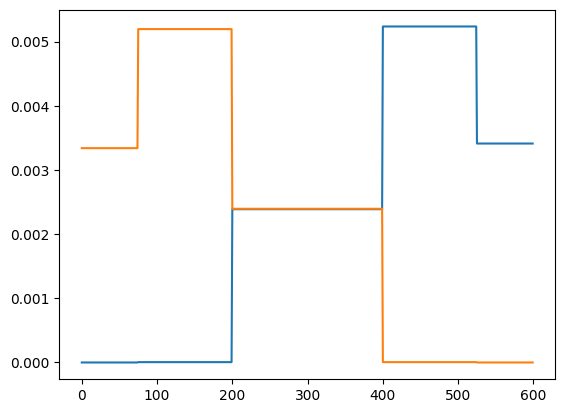

In [36]:
plt.plot(M.X[510, :])
plt.plot(M.X[90, :])

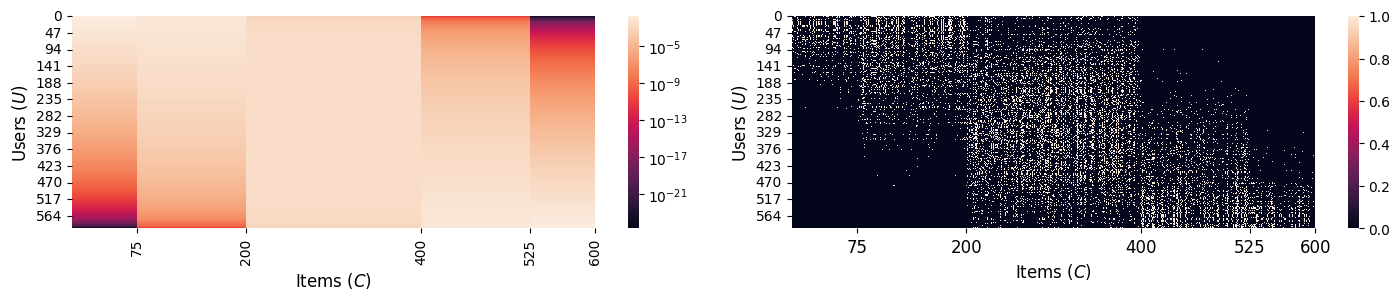

In [22]:

fig, axs = plt.subplots(1,2, figsize=(9,2.5), gridspec_kw={"wspace": 0.1}, sharex=True)

sns.heatmap(M.X, norm=LogNorm(), ax=axs[0])
axs[0].set_ylabel("Users ($U$)", fontsize=12)
axs[0].set_xlabel("Items ($C$)", fontsize=12)

sns.heatmap(S.X, ax=axs[1])
axs[1].set_ylabel("Users ($U$)", fontsize=12)

axs[1].set_xlabel("Items ($C$)", fontsize=12)
axs[1].set_xticks(parameters["list_sizes"].cumsum())
axs[1].set_xticklabels(parameters["list_sizes"].cumsum(), rotation=0, fontsize=12)
set_size(fig, (14,3));

In [26]:
# Creates 100 randomly initialized matrices
vals = {}
vals["parameters"] = parameters
vals["num_matrices"] = 100
vals["matrices"]  = {}
for i in tqdm(range(vals["num_matrices"])):
    S, M = prepare_matrices(parameters, seedv=i)
    vals["matrices"][i] = {"S": S, "M": M}
    
with open("mat.pkl", "wb") as f:
    pickle.dump(vals, f)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [54:54<00:00, 32.95s/it]


In [25]:
from collections import Counter
import pandas as pd

def map_index_to_topic(val,
    list_size=[20, 50, 70, 50, 20], 
    list_names=["L", "CL", "C", "CR", "R"]):
    cumsum = np.array(list_size).cumsum()
    return list_names[(val < cumsum).argmax()]
 

def measure_1_round(M, S, to_add, list_sizes, z=20, user_index=50, selection_mode='random'):
    rv = stats.poisson(z)
    tosses = z # rv.rvs()
    tmp = np.copy(S.X[user_index, :])
    S.X[user_index, :] = np.random.random(S.X.shape[1]) / 10**10
    for ta in to_add:
        S.X[user_index, ta] = 1
    dict_vals = []

    for i in range(tosses):

        scores, recommendations, choice = M.interact(user_index, S, selection_mode=selection_mode)

        tmpd = pd.DataFrame({
            "T": [map_index_to_topic(rec, list_sizes) for rec in recommendations],
            "S": scores
        })
#         print(recommendations)
#         print([map_index_to_topic(rec, list_sizes) for rec in recommendations])
#         print(scores)
#         print(tmpd.groupby("T").S.sum())
#         print(i, ">>", map_index_to_topic(choice, list_sizes))

        for label in [map_index_to_topic(rec, list_sizes) for rec in recommendations]:
            dict_vals.append({
                "idx": i,
                "user_index": user_index,
                "label": label,
                "kind": "recommendation"
            })
        dict_vals.append({
            "idx": i,
            "user_index": user_index,
            "label": map_index_to_topic(choice, list_sizes),
            "kind": "choice"
        })

    
    S.X[user_index, :] = tmp
    
    
    return pd.DataFrame(dict_vals).fillna(0)


In [ ]:
def build_matrices(seed):
    scale = 2
    list_sizes = np.array([75, 125, 200, 125, 75]) 
    n_users = 600
    z = 60
    n_items = np.sum(list_sizes) 
print(n_users, n_items)

In [ ]:
scale = 2
list_sizes = np.array([75, 125, 200, 125, 75]) 
n_users = 600
z = 60
n_items = np.sum(list_sizes) 
print(n_users, n_items)



dfs = []

for sim in range(1):
    np.random.seed(sim)
    S = cfrs.CollaborativeFiltering(n_users=n_users, n_items=n_items, k=10, r=20)
    M = cfrs.Users(n_users=n_users, n_items=n_items,
          list_alphas=[1, 1, 1.3, 5, 12],
          list_betas=[12, 5, 1.3, 1, 1], 
          list_scales=[1, 1.2, 1.5, 1.2, 1],
          list_sizes=list_sizes)
    burn_in(M, S, z=z)

    for i in range(300):
        to_add = [299]#[np.random.choice(list(range(10)))]
    #     print(to_add)
        df = measure_1_round(M, S, to_add, list_sizes, z=20, user_index=599, selection_mode="random")
        df["idy"] = i
        df["sim"] = sim
        dfs.append(df)

dfs = pd.concat(dfs)
#     print(measure_1_r
x = dfs[dfs.kind == "recommendation"].groupby(["idx", "label"]).count().idy.reset_index()
x_norm = dfs[dfs.kind == "recommendation"].groupby(["idx"]).count().idy.reset_index()
plt.plot(x[x.label == "L"].set_index("idx")/x_norm.set_index("idx"), marker="o", color="#1919e6")
plt.plot(x[x.label == "C"].set_index("idx")/x_norm.set_index("idx"), marker="o", color="#808080")
plt.plot(x[x.label == "CL"].set_index("idx")/x_norm.set_index("idx"), marker="o", color="#4d4db3")
plt.plot(x[x.label == "CR"].set_index("idx")/x_norm.set_index("idx"), marker="o", color="#b34d4d")
plt.plot(x[x.label == "R"].set_index("idx")/x_norm.set_index("idx"), marker="o", color="#e61919")
plt.show()

x = dfs[dfs.kind == "choice"].groupby(["idx", "label"]).count().idy.reset_index()
x_norm = dfs[dfs.kind == "choice"].groupby(["idx"]).count().idy.reset_index()
plt.plot(x[x.label == "R"].set_index("idx")/x_norm.set_index("idx"), marker="o", color="#e61919")
plt.plot(x[x.label == "L"].set_index("idx")/x_norm.set_index("idx"), marker="o", color="#1919e6")
plt.plot(x[x.label == "C"].set_index("idx")/x_norm.set_index("idx"), marker="o", color="#808080")
plt.plot(x[x.label == "CL"].set_index("idx")/x_norm.set_index("idx"), marker="o", color="#4d4db3")
plt.plot(x[x.label == "CR"].set_index("idx")/x_norm.set_index("idx"), marker="o", color="#b34d4d")
plt.show()

In [ ]:
for xxx in range(200):
    np.random.seed(xxx)
    S = cfrs.CollaborativeFiltering(n_users=n_users, n_items=n_items, k=10, r=20)
    M = cfrs.Users(n_users=n_users, n_items=n_items,
          list_alphas=[1, 1, 1.3, 5, 12],
          list_betas=[12, 5, 1.3, 1, 1], 
          list_scales=[1, 1.2, 1.5, 1.2, 1],
          list_sizes=list_sizes)
    burn_in(M, S, z=z)

    import pandas as pd
    tmp = [0] + list(list_sizes.cumsum())
    for i, j in zip(tmp[:-1], tmp[1:]):
        print(i, j, pd.Series(S.X.sum(axis=0)[i:j]).sum())
    # pd.Series(S.X.sum(axis=0))


In [ ]:
x = dfs[dfs.kind == "recommendation"].groupby(["idx", "label"]).count().idy.reset_index()
x_norm = dfs[dfs.kind == "recommendation"].groupby(["idx"]).count().idy.reset_index()
plt.plot(x[x.label == "CL"].set_index("idx")/x_norm.set_index("idx"), marker="o", color="#4d4db3")
plt.plot(x[x.label == "CR"].set_index("idx")/x_norm.set_index("idx"), marker="o", color="#b34d4d")

In [ ]:

dfs = []
for i in range(200):
    to_add = [np.random.choice(list(range(10)))]
    print(to_add)
    df = measure_1_round(M, S, to_add, list_sizes, z=20, user_index=0, selection_mode='utility')
    df["idy"] = i
    dfs.append(df)
dfs = pd.concat(dfs)
#     print(measure_1_round(M, S, to_add, 30, 30).groupby("choice").idx.sum())


In [ ]:
x = dfs[dfs.kind == "recommendation"].groupby(["idx", "label"]).count().idy.reset_index()
x_norm = dfs[dfs.kind == "recommendation"].groupby(["idx"]).count().idy.reset_index()
plt.plot(x[x.label == "L"].set_index("idx")/x_norm.set_index("idx"), marker="o", color="#1919e6")
plt.plot(x[x.label == "C"].set_index("idx")/x_norm.set_index("idx"), marker="o", color="#808080")
plt.plot(x[x.label == "CL"].set_index("idx")/x_norm.set_index("idx"), marker="o", color="#4d4db3")
plt.plot(x[x.label == "CR"].set_index("idx")/x_norm.set_index("idx"), marker="o", color="#b34d4d")
plt.plot(x[x.label == "R"].set_index("idx")/x_norm.set_index("idx"), marker="o", color="#e61919")


In [ ]:
x = dfs[dfs.kind == "choice"].groupby(["idx", "label"]).count().idy.reset_index()
x_norm = dfs[dfs.kind == "choice"].groupby(["idx"]).count().idy.reset_index()
plt.plot(x[x.label == "L"].set_index("idx")/x_norm.set_index("idx"), marker="o", color="#1919e6")
plt.plot(x[x.label == "C"].set_index("idx")/x_norm.set_index("idx"), marker="o", color="#808080")
plt.plot(x[x.label == "CL"].set_index("idx")/x_norm.set_index("idx"), marker="o", color="#4d4db3")
plt.plot(x[x.label == "CR"].set_index("idx")/x_norm.set_index("idx"), marker="o", color="#b34d4d")
plt.plot(x[x.label == "R"].set_index("idx")/x_norm.set_index("idx"), marker="o", color="#e61919")
